## Avances de laboratorio

In [6]:
# Importación de librerías

import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

### 2) Carga del dataset/Descripción de los datos

In [7]:
df = pd.read_csv("train.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


El dataset contiene 7,613 tweets con las siguientes columnas:

- id: Identificador
- Keyword: Palabra clave (A veces falta)
- location: lugar (hay muchos valores faltantes)
- text: el contenido del tweet
- target: etiqueta (1 = desastre, 0 = no desastre)

### 3) Limpieza y Preprocesamiento

In [8]:
stop_words = set([
    # stopwords básicas
    "the","a","an","in","on","and","or","but","if","at","by","for","with",
    "about","against","between","into","through","during","before","after",
    "to","from","up","then","once","here","there","when","where","why","how",
    "all","any","both","each","few","more","most","other","some","such","no",
    "nor","not","only","own","same","so","than","too","very","is","are","was",
    "were","be","been","being","of","do","does","did","doing","would","could",
    "should","can","will",

    # pronombres
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
    "yourself","yourselves","he","him","his","himself","she","her","hers",
    "herself","it","its","itself","they","them","their","theirs","themselves",

    # palabras de twitter / conversación
    "amp","rt","im","dont","cant","didnt","doesnt","youre","youve","ive","id",
    "ill","hes","shes","theyre","weve","lets","lol","omg","ugh","got","like",
    "just","know","time","new","day","love","people","going","good","think",
    "want","really","one"
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # Manejo de números: conservar 911 y algunos con palabras relevantes
    tokens = text.split()
    clean_tokens = []
    for i, tok in enumerate(tokens):
        if tok.isdigit():
            if tok == "911":
                clean_tokens.append(tok)
            elif i+1 < len(tokens) and tokens[i+1] in ["dead", "injured", "wounded", "killed"]:
                clean_tokens.append(tok)
            elif i > 0 and tokens[i-1] == "magnitude":
                clean_tokens.append(tok)
        else:
            clean_tokens.append(tok)

    # Quitar stopwords y palabras de 1 caracter
    clean_tokens = [w for w in clean_tokens if w not in stop_words and len(w) > 1]

    return " ".join(clean_tokens)

df["clean_text"] = df["text"].apply(clean_text)
df[["text", "clean_text"]].head(10)

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason this may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",receive evacuation orders california
4,Just got sent this photo from Ruby #Alaska as ...,sent this photo ruby as smoke pours school
5,#RockyFire Update => California Hwy. 20 closed...,update california hwy closed directions due la...
6,#flood #disaster Heavy rain causes flash flood...,heavy rain causes flash flooding streets manit...
7,I'm on top of the hill and I can see a fire in...,top hill see fire woods
8,There's an emergency evacuation happening now ...,theres emergency evacuation happening now buil...
9,I'm afraid that the tornado is coming to our a...,afraid that tornado coming area


Se realizaron las técnicas de limpieza sugeridas como las minusculas, eliminación de URLs, menciones, hashtags y caracteres especiales. Se optó por mantener unos números clave como el 911 que puede ayudar a denotar un desastre o no, magnitud de terremotos, número de muertos/heridos. Se eliminaron stopwords y palabras de un solo carácter ya que estas no dan tanta información al modelo y se creó la columna "clean_text", con el fin de que el modelo se enfoque en palabras significativas como fire, storm, killed, etc.

### Unigramas y bigramas

### 4) Frecuencia de palabras por categoría

In [9]:
# Vectorizar con unigramas y bigramas
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop_words), max_features=5000, min_df=5, max_df=0.9)
X_tfidf = vectorizer.fit_transform(df["clean_text"])
feature_names = vectorizer.get_feature_names_out()

disaster_rows = np.flatnonzero(df["target"].to_numpy() == 1)
non_disaster_rows = np.flatnonzero(df["target"].to_numpy() == 0)

# Promedio de pesos TF-IDF por categoría
disaster_mean = X_tfidf[disaster_rows].mean(axis=0).A1
non_disaster_mean = X_tfidf[non_disaster_rows].mean(axis=0).A1

# Top 20 palabras con más peso en cada clase
top_disaster = sorted(zip(disaster_mean, feature_names), reverse=True)[:20]
top_non_disaster = sorted(zip(non_disaster_mean, feature_names), reverse=True)[:20]

print("Top 20 términos en tweets de desastres:")
for score, word in top_disaster:
    print(word, round(float(score), 4))

print("\nTop 20 términos en tweets de NO desastres:")
for score, word in top_non_disaster:
    print(word, round(float(score), 4))

Top 20 términos en tweets de desastres:
fire 0.0141
this 0.0113
that 0.0112
as 0.01
via 0.0094
have 0.0089
california 0.0089
disaster 0.0084
over 0.0082
police 0.0081
suicide 0.008
storm 0.008
fires 0.0076
has 0.007
buildings 0.0069
killed 0.0068
crash 0.0067
accident 0.0064
emergency 0.0064
news 0.0063

Top 20 términos en tweets de NO desastres:
that 0.0185
this 0.0164
have 0.0141
out 0.0116
get 0.0108
now 0.0093
as 0.0088
what 0.0086
has 0.0086
body 0.0071
via 0.0066
see 0.0065
video 0.0061
back 0.0058
emergency 0.0056
still 0.0056
screaming 0.0054
fire 0.0052
us 0.0051
go 0.0051


El top 10 de las palabras positivas y negativas en cada categoría muestra que si hay cierta relación y se logra diferenciar o separar las palabras conforme la categoria a la que pertenecen. Los tweets de desastres destacan términos como fire, storm, killed, accident, emergency, etc. En no desastres aparecen más palabras cotidianas normales como get, now, video, entre otras. Los bigramas ayudan bastante para poder encontrar las palabras más representativas y así poder clasificar de mejor forma. Aún así también hay palabras comunes que las categorias comparten como that o this.

### 5) Análisis exploratorio

In [10]:
# 5.1 "Palabra más repetida" por categoría
cv = CountVectorizer(ngram_range=(1,2), stop_words=list(stop_words), max_features=5000, min_df=5, max_df=0.9)
X_count = cv.fit_transform(df["clean_text"])
vocab = cv.get_feature_names_out()

disaster_counts = np.asarray(X_count[disaster_rows].sum(axis=0)).ravel()
non_disaster_counts = np.asarray(X_count[non_disaster_rows].sum(axis=0)).ravel()

top_word_disaster = vocab[disaster_counts.argmax()]
top_word_non_disaster = vocab[non_disaster_counts.argmax()]

print("\nPalabra más repetida en DESASTRES:", top_word_disaster)
print("Palabra más repetida en NO DESASTRES:", top_word_non_disaster)


Palabra más repetida en DESASTRES: that
Palabra más repetida en NO DESASTRES: that


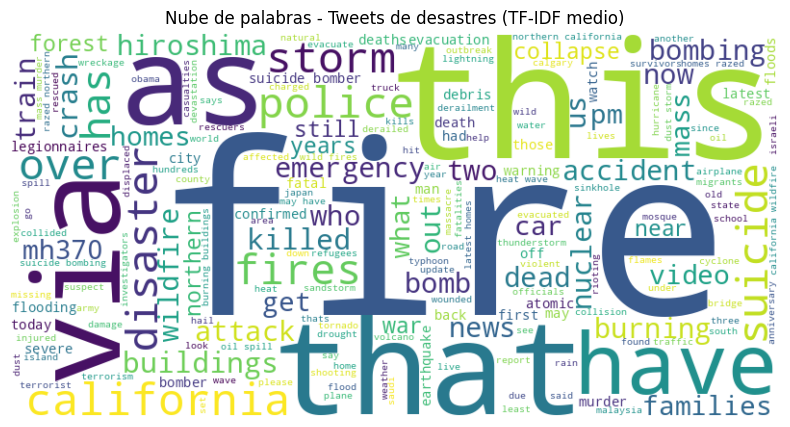

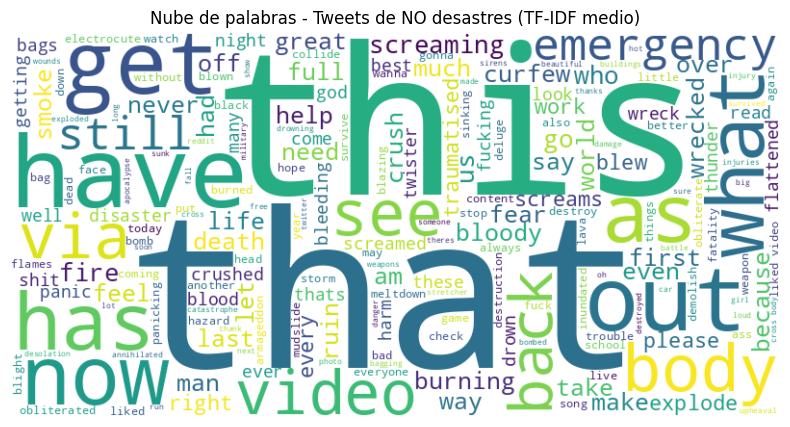

In [11]:
# 5.2 Nube de palabras
plt.figure(figsize=(10,5))
wc_disaster = WordCloud(width=800, height=400, background_color="white") \
    .generate_from_frequencies(dict(zip(feature_names, disaster_mean)))
plt.imshow(wc_disaster, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets de desastres (TF-IDF medio)")
plt.show()

plt.figure(figsize=(10,5))
wc_non_disaster = WordCloud(width=800, height=400, background_color="white") \
    .generate_from_frequencies(dict(zip(feature_names, non_disaster_mean)))
plt.imshow(wc_non_disaster, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets de NO desastres (TF-IDF medio)")
plt.show()

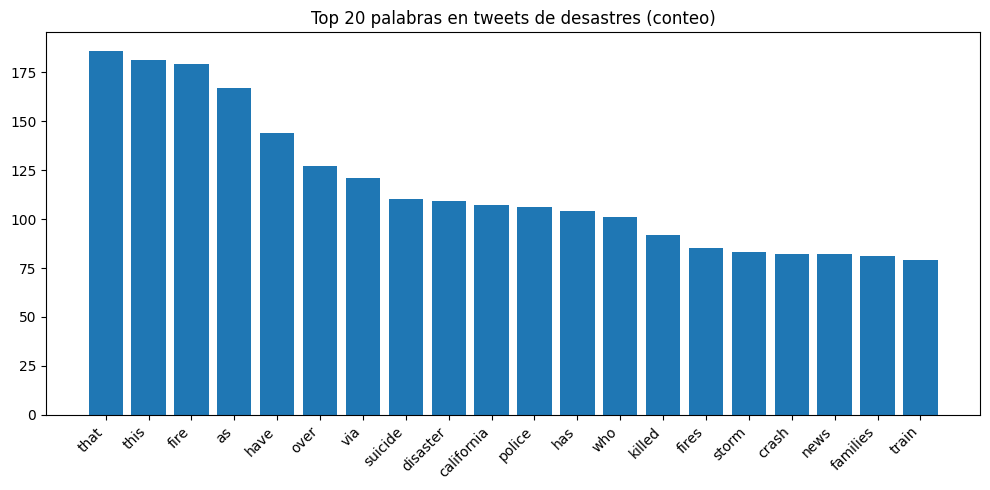

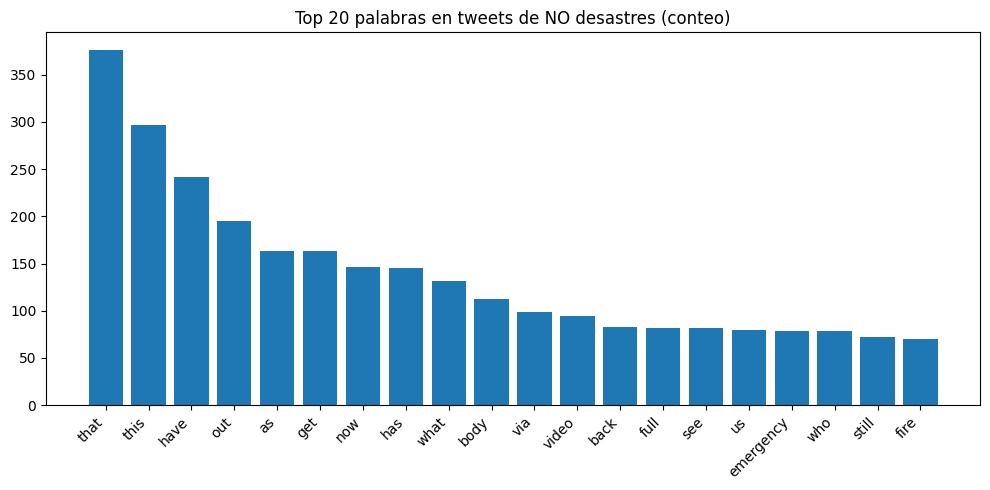

In [12]:
# 5.3 Histogramas de las palabras más frecuentes
def plot_top_bars(words, counts, title, k=20):
    idx = np.argsort(counts)[::-1][:k]
    sel_words = words[idx]
    sel_counts = counts[idx]
    plt.figure(figsize=(10,5))
    plt.bar(sel_words, sel_counts)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_bars(vocab, disaster_counts, "Top 20 palabras en tweets de desastres (conteo)")
plot_top_bars(vocab, non_disaster_counts, "Top 20 palabras en tweets de NO desastres (conteo)")

Se generaron nubes de palabras y gráficos de frecuencias, los que ayudan a confirmar que hay superposición de vocabulario que puede llegar a complicar la clasificación. En las nubes de palabras se puede observar una clasificación de palabras, en general, bastante aceptable. Por otro lado, en los gráficos de frecuencias se puede notar que la palabra que más aparece es that y es común en las dos categorias.

In [13]:
# 5.4 Palabras presentes en ambas categorías
disaster_present_mask = disaster_counts > 0
non_disaster_present_mask = non_disaster_counts > 0
common_in_both = set(vocab[disaster_present_mask]) & set(vocab[non_disaster_present_mask])

print("\nNúmero de palabras comunes en ambas categorías:", len(common_in_both))
print("Ejemplos de palabras comunes:", list(common_in_both)[:30])


Número de palabras comunes en ambas categorías: 2560
Ejemplos de palabras comunes: ['rolling', 'warning', 'anthrax', 'idk', 'poll', 'blessings', 'blast', 'seeks', 'came land', 'as many', 'charge', 'san', 'light', 'fall', 'wild horse', 'mayan tablet', 'still have', 'root', 'tells', 'standard', 'trent bridge', 'rape', 'battlefield', 'cliff', 'within', '10th', 'derail', 'national', 'exploration', 'dream']


Más de 2500 palabras son comunes en ambas categorías

### 6) Descripción del modelo preliminar de clasificación

Para este problema de clasificación de tweets de desastre y no desastre natural, se pueden utilizar varios algoritmos de Machine Learning supervisado.

Podría usar Regresión logística el cuál es rápido y efectivo con texto, también podría ser Naive Bayes (multinomialNB) que es clásico para clasificación de texto, aprovecha la frecuencia de palabras. Support vector machine (SVM) igualmente funciona bien con texto y datos lineales o no lineales. Por otro lado está Random Forest con el que ya se está familiarizado, funciona bien en interacciones no lineales, pero si puede presentar menos eficiencia si el texto es muy disperso y Redes Neuronales simples (MPLClassifier) que permite capturar patrones más complejos.

Hay que tener en cuenta que se utilizaran no solo palabras individuales (unigramas), sino también bigramas (pared de palabras como "forest fire", "earthquake damage") y posiblemente trigramas, lo cual es un punto que ayuda a diferenciar o identificar entre desastres reales de expresiones figurativas.

Se seleccionaron los modelos de **Regresión Logística, Naive Bayes y Random Forest** para ver qué tal es su desempeño y si se comprueba su eficiencia en cuanto al manejo de texto.

In [14]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df["text"].astype(str))
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))


Logistic Regression
Accuracy: 0.7957977675640184
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       874
           1       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523


Naive Bayes
Accuracy: 0.7925147734734077
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.81      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523


Random Forest
Accuracy: 0.778069599474721
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       874
           1       0.81      0.63      0.71       649

    accuracy                           0.78    

A los modelos se les hizo una división 80/20 para train-test. Según se puede observar en los resultados de las métricas, el modelo de Regresión Logística obtuvo un accuracy de 80% aproximadamente con un mejor equilibrio entre precisión y recall. En el caso de Naive Bayes, su accuracy fue de 79% que es similar al primer modelo y por último el modelo de Random Forest obtuvo un accuracy con valor de 78%, es el modelo con menor precisión, probablemente porque el texto es muy disperso y RF no maneja tan bien datos de alta dimensionalidad, sin embargo, su rendimiento tampoco es tan malo.

Por lo tanto, el mejor modelo fue el de Regresión Logística, que fue el que tuvo una mejor precisión.

### 7) Función para clasificar un Tweet

In [15]:
def clasificar_tweet(model, vectorizer):
    tweet = input("Escribe un tweet: ")
    tweetPre = clean_text(tweet)
    tweetVec = vectorizer.transform([tweetPre])
    pred = model.predict(tweetVec)[0]

    if pred == 1:
        print("Clasificación: ¡Desastre! :(")
    else:
        print("Clasificación: No Desastre :)")

clasificar_tweet(models["Logistic Regression"], vectorizer)

Escribe un tweet: Damage to school bus on 80 in multi car crash #BREAKING
Clasificación: ¡Desastre! :(


Para este input, se tomó el mejor modelo (Regresión Logística). se puede notar que el modelo logra clasificar los tweets de manera correcta, definiendo si es desastre o no.

### 8) Análisis de sentimiento

Se aplicó VADER Sentiment Analyzer para extraer el sentimiento (positivo, negativo o neutro) y se definieron dos ejemplos para probarlo

In [16]:
sia = SentimentIntensityAnalyzer()

def analizar_sentimiento(tweet):
    score = sia.polarity_scores(tweet)
    if score["compound"] >= 0.05:
        return "Positivo 😀", score
    elif score["compound"] <= -0.05:
        return "Negativo 😡", score
    else:
        return "Neutral 😐", score

# Ejemplo
print(analizar_sentimiento("I am so happy with the help after the earthquake"))
print(analizar_sentimiento("Terrible explosion killed many people"))

('Positivo 😀', {'neg': 0.0, 'neu': 0.518, 'pos': 0.482, 'compound': 0.8147})
('Negativo 😡', {'neg': 0.717, 'neu': 0.283, 'pos': 0.0, 'compound': -0.8225})


Al calcular el promedio de sentimientos, se obtuvo que el tweet de desastre es más negativo y el de no desastre menos negativo. Lo anterior confirma que si vale la pena dejar los emoticones ya que transmiten directamente las emociones, lo que ayuda a diferenciar las categorias.

### 9) top 10 tweets negativos y positivos

In [17]:
df["sentiment"] = df["text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# 9.1 Top negativos
top_negativos = df.sort_values("sentiment").head(10)[["text", "target", "sentiment"]]
print("\nTop 10 Negativos:\n", top_negativos)

# 9.2 Top positivos
top_positivos = df.sort_values("sentiment", ascending=False).head(10)[["text", "target", "sentiment"]]
print("\nTop 10 Positivos:\n", top_positivos)

# 9.3 Comparar negatividad entre categorias
promedio_negatividad = df.groupby("target")["sentiment"].mean()
print("\nPromedio de sentimiento por categoría (más bajo = más negativo):")
print(promedio_negatividad)

if promedio_negatividad[1] < promedio_negatividad[0]:
    print("Los tweets de DESASTRES son más negativos.")
else:
    print("Los tweets de NO DESASTRES son más negativos.")


Top 10 Negativos:
                                                    text  target  sentiment
7472  wreck? wreck wreck wreck wreck wreck wreck wre...       0    -0.9883
6414  @Abu_Baraa1 Suicide bomber targets Saudi mosqu...       1    -0.9686
6411  Suicide bomber kills 15 in Saudi security site...       1    -0.9623
6393  ? 19th Day Since 17-Jul-2015 -- Nigeria: Suici...       1    -0.9595
6830  @dramaa_llama but otherwise i will stay trappe...       0    -0.9556
6407  17 killed in SÛªArabia mosque suicide bombing...       1    -0.9552
2932  at the lake \n*sees a dead fish*\nme: poor lit...       0    -0.9549
472   illegal alien released by Obama/DHS 4 times Ch...       1    -0.9538
1540  Bomb Crash Loot Riot Emergency Pipe Bomb Nucle...       1    -0.9524
6930  @cspan #Prez. Mr. President you are the bigges...       1    -0.9493

Top 10 Positivos:
                                                    text  target  sentiment
6992  Check out 'Want Twister Tickets AND A VIP EXPE...     

Según los resultados, en el promedio de sentimientos se puede notar que **los tweets de desastres son los más negativos** con un valor de -0.26, mientras que los tweets de no desastres son menos negativos con un valor promedio de -0.05

### 10) Análisis final de tweets

In [18]:
sia = SentimentIntensityAnalyzer()

# Crear columna con la negatividad
df['negativity'] = df['text'].apply(lambda x: sia.polarity_scores(x)['neg'])
df[['text', 'negativity']].head()

,text,negativity
0,Our Deeds are the Reason of this #earthquake M...,0.000
1,Forest fire near La Ronge Sask. Canada,0.286
2,All residents asked to 'shelter in place' are ...,0.095
3,"13,000 people receive #wildfires evacuation or...",0.000
4,Just got sent this photo from Ruby #Alaska as ...,0.000


Incluir la nueva variable en el dataset

In [19]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['text'])

# Concatenar la feature adicional
import numpy as np
X = hstack([X_text, np.array(df['negativity']).reshape(-1,1)])

y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.83      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523



Al añadir la feature extra "negativity" al vector TF-IDF, el accuracy incrementó su valor a 81% con Regresión logística, asimismo el recall, lo que indica que incorporar variables que manejen sentimientos, mejora el modelo.

Comparar resultados

In [21]:
# Modelo SIN negatividad
X_text_only = vectorizer.fit_transform(df['text'])
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_text_only, y, test_size=0.2, random_state=42)

clf_text = LogisticRegression(max_iter=1000)
clf_text.fit(X_train_t, y_train_t)
y_pred_t = clf_text.predict(X_test_t)

print("Resultados SOLO texto:\n")
print(classification_report(y_test_t, y_pred_t))

# Modelo CON negatividad
print("Resultados TEXTO + negatividad:\n")
print(classification_report(y_test, y_pred))

Resultados SOLO texto:

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       874
           1       0.82      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Resultados TEXTO + negatividad:

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.83      0.70      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523



Discusión de los resultados

Al incluir la variable de negatividad en el modelo de clasificación, se observa una ligera mejoría en las métricas, como ejemplo, el F1-score para la clase “desastre” aumentó de 0.75 a 0.76, asimismo, la precisión es similar lo que indica que ambos modelos tienen un buen rendimiento. Esto sugiere que la información semántica sobre el tono negativo del tweet aporta señales útiles al modelo. Sin embargo, la mejora no es drástica, lo que indica que la representación TF-IDF ya captura gran parte de las características discriminativas.

### Conclusión

El análisis realizado permitió identificar patrones en los tweets y diferenciar entre aquellos que reportan un desastre real y los que no. Después de la limpieza y el preprocesamiento del texto, se comprobó que ciertos términos como fire, storm, killed, accident son característicos de desastres, mientras que expresiones más genéricas como get, now, video aparecen en tweets no relacionados.

Al hacer evaluación en diferentes algoritmos, la Regresión Logística mostró el mejor desempeño con un valor de 81% de exactitud, superando a Naive Bayes y Random Forest. Además, el agregar la variable de sentimiento (negatividad) mejoró los resultados, evidenciando que los tweets sobre desastres tienden a ser más negativos que los demás.

El modelo es capaz de distinguir con buena precisión entre tweets de desastres y no desastres, también se comprobó que complementar la representación del texto con el análisis de sentimientos aporta valor adicional, mejorando la capacidad predictiva del clasificador.